**This notebook contains followings:**
* Data Merging
* Deep Surv


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sksurv.svm import FastSurvivalSVM
from pycox.datasets import metabric

In [14]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [32]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [33]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


In [34]:
#Standardizing cols

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

print (standardize)

x_mapper = DataFrameMapper(standardize + leave)


[(['x0'], StandardScaler()), (['x1'], StandardScaler()), (['x2'], StandardScaler()), (['x3'], StandardScaler()), (['x8'], StandardScaler())]


In [40]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

ValueError: ['x0']: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

In [31]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)

val = x_val, y_val
#val= df_b = pd.DataFrame(columns=['duration', 'event'])
print (val)


(array([[-0.38457575, -0.89326   , -0.74212027, ...,  0.        ,
         0.        ,  1.        ],
       [-0.3665086 , -0.3167301 ,  0.05380753, ...,  1.        ,
         0.        ,  1.        ],
       [-0.5659799 , -0.83177716, -0.9836813 , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-0.5302728 ,  0.5557188 ,  0.24615282, ...,  0.        ,
         0.        ,  1.        ],
       [-0.8310751 ,  0.80899894,  0.56936073, ...,  0.        ,
         0.        ,  1.        ],
       [-0.7328408 ,  0.42610374, -0.10061071, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32), (array([ 85.73333  ,  55.666668 , 143.6      , 117.       , 183.2      ,
       151.9      ,  37.8      , 128.36667  , 141.56667  ,   2.5333333,
       225.5      ,  21.9      , 174.56667  , 130.46666  , 113.566666 ,
        34.3      , 163.1      , 111.53333  , 128.2      ,  17.833334 ,
        55.733334 , 226.7      , 239.16667  , 168.26666  , 176.36667  ,
        8

# Deep surv model

In [21]:
in_features = x_train.shape[1]
num_nodes = [128, 128]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

print (x_train.shape)
#x_train = torch.from_numpy(x_train)
#x_train= torch.reshape(x_train,(256, 1, len(x_train)))
# x_train = x_train[:,:,None]
# print (x_train.shape)

(1218, 9)


In [144]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.lin_first = torch.nn.Linear(in_features, 32)
        self.conv_7= torch.nn.Conv1d(in_channels= 256, out_channels= 32, kernel_size= 7, padding= 'same')
        self.max_pool= torch.nn.MaxPool1d (kernel_size=3, stride=1, padding=1)
        self.avg_pool= torch.nn.AdaptiveAvgPool1d(32)    
        self.conv_3= torch.nn.Conv1d(in_channels= 32, out_channels= 32, kernel_size= 3, padding= 'same')
        self.lin = torch.nn.Linear(32, 32)
        self.lin_out = torch.nn.Linear(32, out_features)
        self.batchn= torch.nn.BatchNorm1d(9)
        self.drop= torch.nn.Dropout(0.1)
        self.relu = torch.nn.ReLU()

    def forward(self, x_tensor):
        print (x_tensor.shape)
        # x= self.lin_first(x_tensor)
        # x= self.relu (x)
        # x= self.batchn (x)
        # x= self.drop(x)
        x= self.conv_7(x_tensor)
        x= self.batchn(x)
        x= self.max_pool(x)
        x_add= self.drop(x)

        x= self.conv_3(x_add)
        x= self.batchn(x)
        x= self.relu(x)
        x= self.conv_3(x)
        x= self.batchn(x)

        x= x_add + x
        x= self.relu(x)


        x= self.avg_pool(x)
        return self.lin_out(x)

    def predict(self, x_tensor):
        x = self.forward(x_tensor)
        return x
net = Net()

In [22]:
model = CoxPH(net, tt.optim.Adam)

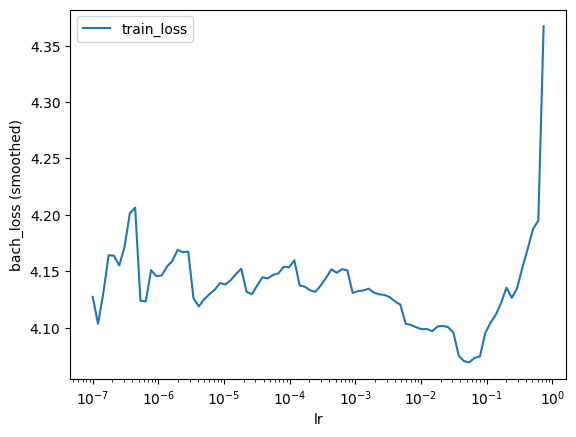

In [23]:
batch_size = 128
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [24]:
lrfinder.get_best_lr()

0.005462277217684369

In [25]:
model.optimizer.set_lr(0.001)

In [26]:
epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [27]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

IndexError: tuple index out of range

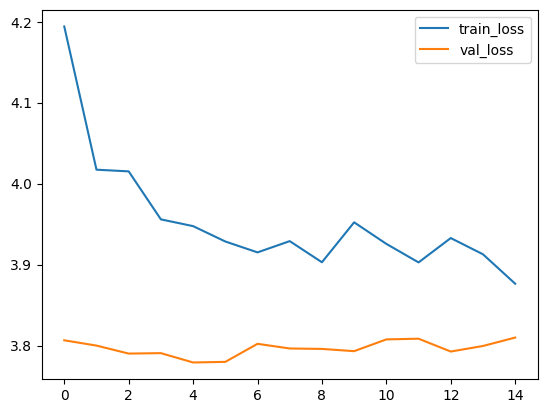

In [192]:
_ = log.plot()

In [193]:
model.partial_log_likelihood(*val).mean()

-4.9856305

In [194]:
_ = model.compute_baseline_hazards()

In [195]:
surv = model.predict_surv_df(x_test)

For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

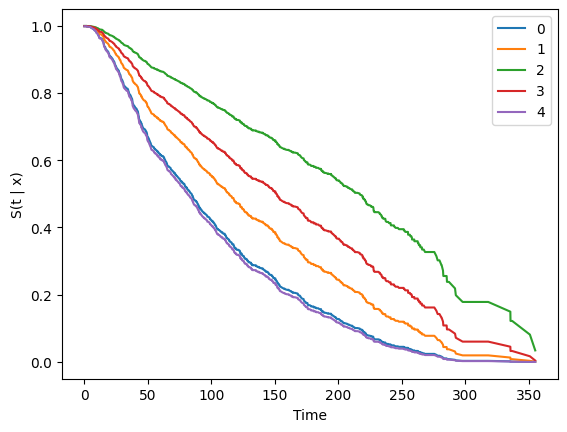

In [196]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. 
Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [197]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

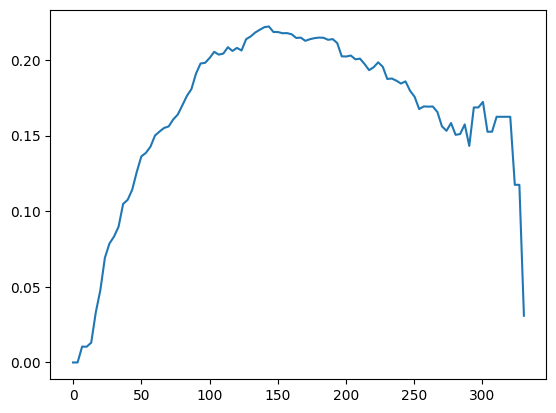

In [198]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [199]:
ev.integrated_brier_score(time_grid)

0.1661420360317745

In [200]:
ev.concordance_td()

0.6610442447872521

In [201]:
ev.integrated_nbll(time_grid)

0.5027428944048523